# Comp 540 Blogpost 2

In this blog post we'll create a UNet and train it on the dataset.

The UNet is a fully convolutional neural network for image segmentation. The structure is depicted below

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In the encoder layers (the first half the network) the network will learn to localize the object it is trying to segment. However, because the image gets heavily downsampled, the localization is very rough. The second half of the network (the decoder layers) will then use the outputs from the previous layers to clean up the segmentation and make it more fine grained and accurate.

Let's get started and load the data:

In [9]:
import logging
import os
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from pyjet.data import NpDataset, DatasetGenerator

from training import load_model, load_train_setup
from models.model_utils import reset_model
import data_utils as dsb
from utils import safe_open_dir
from run_model import train_model, test_model

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

# Set up some globals
SEED = 42
np.random.seed(SEED)

TRAIN_ID = "train-unet-0"
train_config = load_train_setup(TRAIN_ID)
print("Training Configuration:")
pprint(train_config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training Configuration:
{'batch_size': 16,
 'epochs': 10,
 'img_size': [256, 256],
 'kfold': 10,
 'model': 'unet-0',
 'seed': 7}


In [2]:
train_ids, x_train, y_train = dsb.load_train_data(path_to_train="../input/train/", 
                                                  img_size=train_config["img_size"],
                                                  num_channels=3)

2018-03-24 17:56:41,489 : INFO : Loading 670 train images
100%|██████████| 670/670 [01:32<00:00,  7.21it/s]


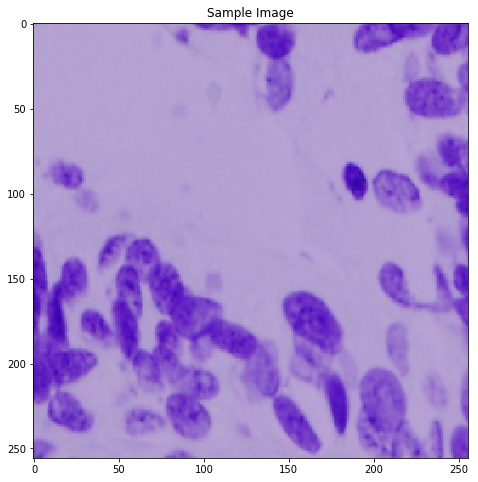

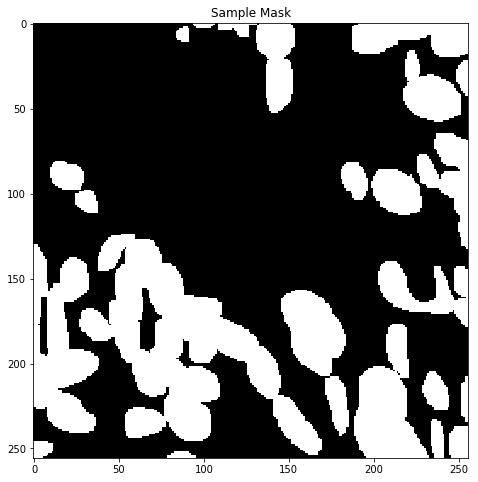

In [3]:
# Choose a random image to display
img_id = np.random.randint(len(x_train))
plt.imshow(x_train[img_id])
plt.title("Sample Image")
plt.show()
plt.imshow(y_train[img_id,...,0], cmap='gray')
plt.title("Sample Mask")
plt.show()

Now we'll go ahead and train our UNet. We'll be using the binary cross-entropy loss, which means this problem will be treated like a pixel classification problem: classify whether a pixel belongs to a nucleus or not. We'll also be optimizing with Adam.

In [4]:
# Construct a dataset from the data and split the data
dataset = NpDataset(x=x_train, y=y_train, ids=train_ids)
logging.info("Total Data: %s samples" % len(dataset))
train_dataset, val_dataset = dataset.validation_split(split=0.2, shuffle=True, seed=np.random.randint(2 ** 32))

# Load the model
model = load_model(train_config["model"])

# Train the model
model, history = train_model(model, TRAIN_ID, train_dataset, val_dataset,
                             epochs=train_config["epochs"], 
                             batch_size=train_config["batch_size"])

2018-03-24 17:58:14,755 : INFO : Total Data: 670 samples


Instructions for updating:
keep_dims is deprecated, use keepdims instead


2018-03-24 17:58:15,600 : WARNING : From /home/abhmul/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1349: calling reduce_mean (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
2018-03-24 17:58:18,474 : INFO : Train Data: 536 samples
2018-03-24 17:58:18,475 : INFO : Val Data: 134 samples
2018-03-24 17:58:18,475 : INFO : Resetting model parameters
2018-03-24 17:58:18,525 : INFO : reinitializing layer conv2d_1.kernel
2018-03-24 17:58:18,536 : INFO : reinitializing layer conv2d_1.bias
2018-03-24 17:58:18,550 : INFO : reinitializing layer batch_normalization_1.gamma
2018-03-24 17:58:18,564 : INFO : reinitializing layer batch_normalization_1.beta
2018-03-24 17:58:18,579 : INFO : reinitializing layer batch_normalization_1.moving_mean
2018-03-24 17:58:18,594 : INFO : reinitializing layer batch_normalization_1.moving_variance
201

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 64          input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 1 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

2018-03-24 17:58:18,665 : INFO : reinitializing layer batch_normalization_2.moving_mean
2018-03-24 17:58:18,677 : INFO : reinitializing layer batch_normalization_2.moving_variance
2018-03-24 17:58:18,688 : INFO : reinitializing layer conv2d_3.kernel
2018-03-24 17:58:18,699 : INFO : reinitializing layer conv2d_3.bias
2018-03-24 17:58:18,710 : INFO : reinitializing layer batch_normalization_3.gamma
2018-03-24 17:58:18,720 : INFO : reinitializing layer batch_normalization_3.beta
2018-03-24 17:58:18,733 : INFO : reinitializing layer batch_normalization_3.moving_mean
2018-03-24 17:58:18,744 : INFO : reinitializing layer batch_normalization_3.moving_variance
2018-03-24 17:58:18,757 : INFO : reinitializing layer conv2d_4.kernel
2018-03-24 17:58:18,769 : INFO : reinitializing layer conv2d_4.bias
2018-03-24 17:58:18,781 : INFO : reinitializing layer batch_normalization_4.gamma
2018-03-24 17:58:18,794 : INFO : reinitializing layer batch_normalization_4.beta
2018-03-24 17:58:18,806 : INFO : reini

2018-03-24 17:58:19,986 : INFO : reinitializing layer batch_normalization_19.moving_mean
2018-03-24 17:58:19,999 : INFO : reinitializing layer batch_normalization_19.moving_variance
2018-03-24 17:58:20,013 : INFO : reinitializing layer conv2d_20.kernel
2018-03-24 17:58:20,026 : INFO : reinitializing layer conv2d_20.bias


Epoch 1/10
34/34 [==============================] - 43s 1s/step - loss: 0.2709 - mean_iou: 0.4516 - val_loss: 1.0813 - val_mean_iou: 0.5126
Epoch 2/10
34/34 [==============================] - 35s 1s/step - loss: 0.1661 - mean_iou: 0.5343 - val_loss: 0.6587 - val_mean_iou: 0.5560
Epoch 3/10
34/34 [==============================] - 35s 1s/step - loss: 0.1727 - mean_iou: 0.5676 - val_loss: 0.9725 - val_mean_iou: 0.5754
Epoch 4/10
34/34 [==============================] - 35s 1s/step - loss: 0.1563 - mean_iou: 0.5816 - val_loss: 0.6829 - val_mean_iou: 0.5895
Epoch 5/10
34/34 [==============================] - 35s 1s/step - loss: 0.1271 - mean_iou: 0.5964 - val_loss: 0.3369 - val_mean_iou: 0.6095
Epoch 6/10
34/34 [==============================] - 35s 1s/step - loss: 0.1129 - mean_iou: 0.6209 - val_loss: 0.1326 - val_mean_iou: 0.6316
Epoch 7/10
34/34 [==============================] - 35s 1s/step - loss: 0.1024 - mean_iou: 0.6417 - val_loss: 0.1136 - val_mean_iou: 0.6513
Epoch 8/10
34/34 [==

Let's plot and examine the training curves

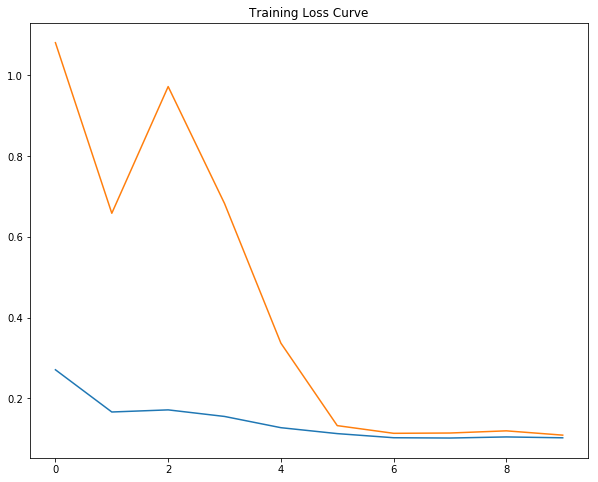

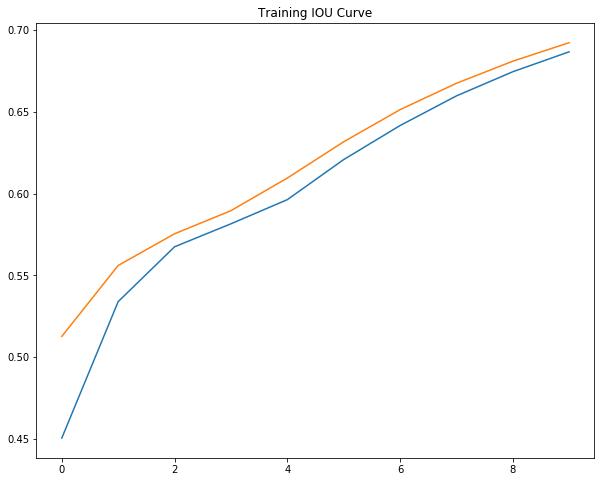

In [5]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training Loss Curve")
plt.show()

plt.plot(history.history["mean_iou"])
plt.plot(history.history["val_mean_iou"])
plt.title("Training IOU Curve")
plt.show()

In the above plots, the training curve is in blue and the validation curve is in orange. Some quick conclusions we can draw
* The network needs to train for longer than 10 epochs. We can see the network has not yet begun to overfit and the mean IOU is still rising.
* The training loss falls almost immediately but the validation loss takes a while to get there. We might think the network is overfitting to the training data at that stage in training, but the validation mean IOU is always above the training IOU during training. This is probably because the network is learning to just predict 0 and capture the background.

Let's try predicting on the test set and see what the output looks like:

In [6]:
# Load the test data
test_ids, x_test, sizes_test = dsb.load_test_data(path_to_test="../input/test/", 
                                                  img_size=train_config["img_size"], num_channels=3)
test_dataset = NpDataset(x=x_test, ids=test_ids)

Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 78.01it/s]


In [11]:
predictions = test_model(model, TRAIN_ID, test_dataset, train_config["batch_size"])

5/5 [==============================] - 2s 361ms/step


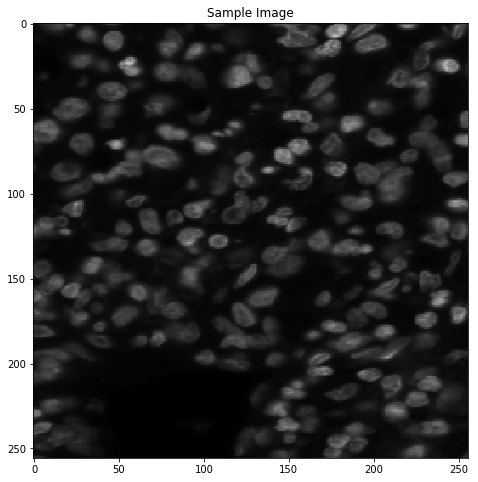

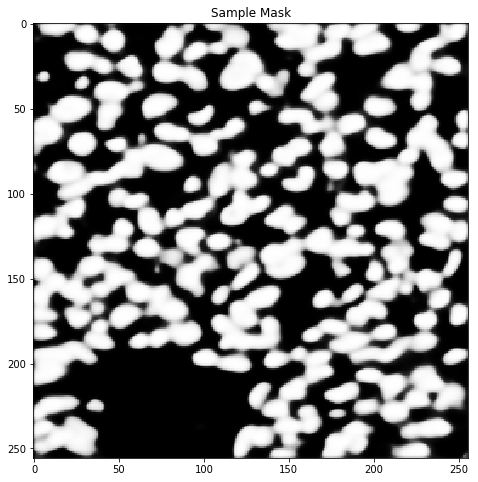

In [17]:
img_id = np.random.randint(len(x_test))
plt.imshow(x_test[img_id])
plt.title("Sample Image")
plt.show()
plt.imshow(predictions[img_id,...,0], cmap='gray')
plt.title("Sample Mask")
plt.show()

Looks like even for needing more training, the output looks pretty good.

## Future Work

We have a decent UNet up and running but there's still a lot more we hope to do

* Cross validate to find an appropriate cutoff threshold for our predicted masks
* Train the UNet using the full image size, so we get more accurate segmentation masks
* Add image augmentation for training and testing
* Train 10-Fold models for better predictions
* Apply postprocessing (like non-maximal suppression) for better quality segmentation masks
* Investigate different neural network architectures such as Mask-RCNN